# **Assignment-2: Car Reviews**
# **Part-1**

Naive Bayes Classifier Implementation with Bag of Words for Sentiment Analysis of Car Reviews 

In [1]:
# import necessary libraries and download nlkt packages
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier

from collections import Counter
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import nltk
import copy
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt

import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/ozgur/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ozgur/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ozgur/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### **Naive Bayes Classifier:**
For this assignment, I have used my own Naive Bayes classifier coded from scratch, its class implementation is provided in the cell below.

In [2]:
# Multinomial Naive Bayes Classifier
class NB_Multinomial:
    def __init__(self, alpha):
        self.alpha = alpha
        self.log_class_priors = 0
        self.log_class_conditional_likelihoods = 0
        
    # main function for training
    def fit(self, X_train, y_train):
        
        # inner function to create class priors
        def estimate_log_class_priors():

            # create two arrays for two classes (num_C0: "pos" and num_C1: "neg") 
            num_C0 = np.count_nonzero(y_train == "pos")
            num_C1 = np.count_nonzero(y_train == "neg")
            
            # find the probability of class priors and take their logarithms
            # P(C=0) -- class_priors_C0, P(C=1) -- class_priors_C1
            class_priors_C0 = np.log(num_C0/(num_C0 + num_C1))
            class_priors_C1 = np.log(1 - num_C0/(num_C0 + num_C1))
            
            # create an array including all class priors with length two
            log_class_priors = np.array([class_priors_C0, class_priors_C1])

            return log_class_priors
        
        # inner function to create class conditional likelihoods
        def estimate_log_class_conditional_likelihoods():
             
            #detect the number of words and assign this to k
            k = len(X_train[0])
                
            # get row indices of each classes (0 & 1) within our data
            indices_C0 = np.nonzero(y_train == "pos")
            indices_C1 = np.nonzero(y_train == "neg") 
            
            # create our data for each classes (data_C0 and data_C1)
            data_C0 = X_train[indices_C0]
            data_C1 = X_train[indices_C1]
            
            # calculate the frequency of each message for each of the classes
            # within the whole training set
            num_of_w_class0 = np.count_nonzero(data_C0 != 0, axis=0)
            num_of_w_class1 = np.count_nonzero(data_C1 != 0, axis=0)
            
            # create an array for each class, that includes the probabilities of each keyword 
            # drawn from a bag of words and concatenate them into one array(theta)
            prob_array_0 = np.log((num_of_w_class0 + self.alpha) / ((sum(num_of_w_class0) + k*self.alpha)))
            prob_array_1 = np.log((num_of_w_class1 + self.alpha) / ((sum(num_of_w_class1) + k*self.alpha)))
            theta = np.concatenate(([prob_array_0], [prob_array_1]), axis=0)
            
            return theta
        
        self.log_class_priors = estimate_log_class_priors()
        self.log_class_conditional_likelihoods = estimate_log_class_conditional_likelihoods()
    
    # predict function to provide predictions for the new data
    def predict(self, new_data):     
        prediction_matrix = 0
        # matrix product of new_data and the transpose of log_class_conditional_likelihoods (∑ 𝑤i * log(𝜃𝑐,𝑤𝑖))
        # by doing this matrix product we can greatly decrease the complexity of computation
        pre_prediction_matrix = new_data@self.log_class_conditional_likelihoods.T

        # Here we add P(C=c) to the above matrix so that we calculate the predictions of n_test_samples for 2 classes
        prediction_matrix = np.array([pre_prediction_matrix[:, 0] + self.log_class_priors[0], \
                                      pre_prediction_matrix[:, 1] + self.log_class_priors[1]])

        class_predictions = np.where(prediction_matrix[0, :] > prediction_matrix[1, :], "pos", "neg")
        return class_predictions  

### **CarReview Classifier Class Implementation**
In the below cell, I created a class for CarReview to read the csv file and to define the data_cleaning method

In [3]:
# create a class CarReview
class Sentiment_Classifier:

  # initialize and load file
  def __init__(self, file):
    self.file = pd.read_csv(file)
  
  def data_cleaning(self):
    """method for data cleaning"""

    # convert all words to lower case (so, no case sensitivity)
    df = self.file.apply(lambda x: x.str.lower())
    
    # exclude all punctuation and stopwords and apply stemming
    tokenized_words = df["Review"].apply(word_tokenize)
    stop_words = stopwords.words('english')    
    stop_words_dict = Counter(stop_words)
    ps = PorterStemmer()

    df["Review"] = tokenized_words.apply(lambda line: " ".join([ps.stem(word) \
                  for word in filter(lambda token: token not in stop_words_dict, line)]))
    
    return df  

### **Car Review Object Creation and Data Cleaning**

Below I created CarReview object and called data_cleaning method to clean the data (exclude all punctuation and stopwords and apply stemming, convert all words to lower case to ensure no case sensitivity)

In [4]:
# create CarReview object as a classifier and load file
car_review = Sentiment_Classifier("car-reviews.csv")

# demonstrate data cleaning, stop-words and punctuations are excluded
df = car_review.data_cleaning()

### **Demonstration 1: Excluding Words and Punctuation and Removing Case Sensitivity**

Below cell includes the demonstration for the exclusion of words and punctuation ,which do not affect sentiment, from the classifier, and the remaining words are not processed in a case sensitive way.

First 5 lines are from the original CSV and the last 5 lines are from the modified one. As can be seen from the two, words like "In, The, My, I, As etc." were excluded from the text.

Moreover, all words were converted to lower case so that there will be no case sensitivity in our classifier.

In [5]:
# demonstration for the words and punctuation which do not affect sentiment
# were excluded from the classifier, and the remaining words
# are not processed in a case sensitive way
print(car_review.file["Review"][:5], "\n")
print(df["Review"][:5])

0     In 1992 we bought a new Taurus and we really ...
1     The last business trip  I drove to San Franci...
2     My husband and I purchased a 1990 Ford F250 a...
3     I feel I have a thorough opinion of this truc...
4     AS a mother of 3  all of whom are still in ca...
Name: Review, dtype: object 

0    1992 bought new tauru realli love 1999 decid t...
1    last busi trip drove san francisco went hertz ...
2    husband purchas 1990 ford f250 noth problem ow...
3    feel thorough opinion truck compar post evalu ...
4    mother 3 still carseat logic thing trade 200sx...
Name: Review, dtype: object


### **Demonstration 2: Stemming**
As can be seen from the below cell a proper stemming has been applied to the text and words with the same stem have been recognised and treated as variatons of the stem.

First 5 lines are from the original CSV and the last 5 lines are from the modified one. As an example, when we compare the two we can easily see the below conversions indicating that the same stem have been recognized amd treated as variations of them.

*   If we compare the second rows (index 1) we can see the below variatons.
 *   thinking --> think
 *   looked --> look
 *   comfortable --> comfort

*   If we compare the third rows (index 2) we can see the below variaton.
 *   owned --> own
*   If we compare the fifth rows (index 5) we can see the below variaton.
 *   logical --> logic

In [6]:
# stem demonstration
pd.set_option("display.max_colwidth", 200)
print(car_review.file["Review"][:5], "\n")
print(df["Review"][:5])

0     In 1992 we bought a new Taurus and we really loved it  So in 1999 we decided to try a new Taurus  I did not care for the style of the newer version  but bought it anyway I do not like the new car...
1     The last business trip  I drove to San Francisco  I went to Hertz Rentals and got a 1999 Ford Taurus  thinking it looked comfortable and professional  I found the seating to be uncomfortable for ...
2     My husband and I purchased a 1990 Ford F250 and had nothing but problems  we have owned the vehicle approximately two years and it has spent at least half of that time in the shop The first probl...
3     I feel I have a thorough opinion of this truck compared to most who post evaluations of their vehicles  My truck has been owned by me since new and currently have 75k miles  ive been meticulous w...
4     AS a mother of 3  all of whom are still in carseats  the only logical thing to do was to trade in my 200sx for a minivan  As the minivan is only one of a handful of vehicles 

### **Demonstration 3: Vectors**
In the cell below, a vector output of a small sample of reviews is shown. Each row represents one review as a vector and each element of a vector represents the number of times that a word appears

In [7]:
# vector demonstration for each review
# each row represents one review as a vector
# and each element of a vector represents the number of times
# that a word appears
vectorizer_demo = CountVectorizer()
vectors_demo = vectorizer_demo.fit_transform(df["Review"])
print(vectors_demo.toarray()[:20, :28])
print(vectors_demo.shape)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

### **Demonstration 4: Split Data into Train and Test Sets**
In the below cell, data is splitted into randomly selected 80% train and 20% test sets.

Afterwards, as also explained in the code, first X_train is vectorized and then X_test is encoded accordingly so that words which are not in training set are dropped from the test set. It is preferred to create a binary vectorizer for better classifier performance.

In [8]:
# data is splitted into 80% train and 20% test sets
# train set is also splitted into 80% train and 20% validation sets
X = df["Review"]
y = df["Sentiment"].to_numpy()

# create train/test split with 80% train and 20% test set
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, y, test_size=0.2, random_state=8)

# first vectorize X_train and then encode X_test and X_validation accordingly
# so that we dropped words which are not in training set from test and validation sets
vectorizer_nb = CountVectorizer(binary=True) # create binary vectorizer for better performance
vectorizer_nb.fit(X_train_df)
X_train_nb = vectorizer_nb.transform(X_train_df).toarray()
X_test_nb = vectorizer_nb.transform(X_test_df).toarray()
y_train_nb, y_test_nb = y_train_df, y_test_df

### **Demonstration 5: Naive Bayes Model Classification and Model Training**
In the cell below, mutinomial Naive Bayes classifier which is coded from scratch is used for classification. First of all, the optimum alpha is calculated using cross validation algorithm and NB_classifier object is created and trained with only training data X_train accordingly.

Since I already run this and decided that the optimum alpha is 1, I left the optimum alpha calculation as an option. If test variable set to "True" then the calculation can be observed accordingly.

In [9]:
# cross validation function which returns cross_val_score for each fold
# in case needed, to enable it please change "test" varibale to "True"
test = False
if test:
    def cross_validation(classifier, X_train, y_train, num_of_folds):
        cross_val_score = []
        cross_val_predictions = []
        classifier = copy.deepcopy(classifier)

        # deep copy of X_train, y_train
        X_train_copy = copy.deepcopy(X_train)
        y_train_copy = copy.deepcopy(y_train)

        # number of rows in one fold
        num_of_rows = len(X_train_copy) // num_of_folds

        # reminder for the last fold to be added
        remainder = len(X_train_copy) % num_of_folds 

        # split the data according to data folds and compute cross_val_score and cross_val_predictions.
        for i in range(1, num_of_folds+1):      
            if i == num_of_folds:
                X_test_data = X_train_copy[num_of_rows*(i-1):num_of_rows*(i)+remainder]
                y_test_data = y_train_copy[num_of_rows*(i-1):num_of_rows*(i)+remainder]
                X_train_data = np.concatenate((X_train_copy[:num_of_rows*(i-1), :], X_train_copy[num_of_rows*i+remainder:, :]), axis=0)
                y_train_data = np.concatenate((y_train_copy[:num_of_rows*(i-1)], y_train_copy[num_of_rows*i+remainder:]), axis=0)
            else:
                X_test_data = X_train_copy[num_of_rows*(i-1):num_of_rows*(i)]
                y_test_data = y_train_copy[num_of_rows*(i-1):num_of_rows*(i)]
                X_train_data = np.concatenate((X_train_copy[:num_of_rows*(i-1), :], X_train_copy[num_of_rows*i:, :]), axis=0)
                y_train_data = np.concatenate((y_train_copy[:num_of_rows*(i-1)], y_train_copy[num_of_rows*i:]), axis=0)

            classifier.fit(X_train_data, y_train_data)
            predictions = list(classifier.predict(X_test_data))
            fold_accuracy = np.count_nonzero(predictions == y_test_data)/y_test_data.shape[0]
            cross_val_score.append(round(fold_accuracy, 3))

        return cross_val_score

    # function to find optimum alpha
    def find_opt_alpha(classifier, X_train, y_train, alpha_max, num_of_folds):
        max_avg_cross_val_score = 0
  
        for alpha in range(1, alpha_max):
            cross_val_score = cross_validation(classifier(alpha=alpha), X_train, y_train, num_of_folds) 
            avg_cross_val_score = round(sum(cross_val_score), 3) / num_of_folds

            if avg_cross_val_score > max_avg_cross_val_score:
                max_avg_cross_val_score = avg_cross_val_score
                opt_alpha = alpha

        return opt_alpha

    # find optimum alpha using 10 folds cross validation
    opt_alpha = find_opt_alpha(NB_Multinomial, X_train_nb, y_train_nb, 20, 10)
    print("Optimum alpha is:", opt_alpha)

# mutinomial Naive Bayes classifier which is coded from scratch is used for classification
NB_classifier = NB_Multinomial(alpha=1)

# train the classifier with only the training data
NB_classifier.fit(X_train_nb, y_train_nb)

### **Demonstration 6: Confusion Matrix Demonstration**
In the below cell, it can be seen that there is the code implementation for calculating the general accuracy on test data and the confusion matrix creation. Finally, a classification report is created for showing the metrics such as precision, recall and f1 for Naive Bayes with BOW algorithm.

 X_test accuracy is:  0.801 

 Confusion Matrix with Naive Bayes/BOW is:
 


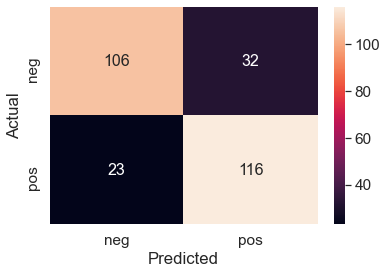

 # of True Negatives 	: 106 
 # of False Positives 	: 32 
 # of False Negatives 	: 23 
 # of True Positives 	: 116 

 Classification report : 
                precision    recall  f1-score   support

         neg       0.82      0.77      0.79       138
         pos       0.78      0.83      0.81       139

    accuracy                           0.80       277
   macro avg       0.80      0.80      0.80       277
weighted avg       0.80      0.80      0.80       277



In [10]:
### confusion matrix performance of Naive Bayes Algorithm woth BOW ###

# calculate test accuracy
predictions1 = NB_classifier.predict(X_test_nb)
accuracy1 = round(np.count_nonzero(predictions1 == y_test_nb)/y_test_nb.shape[0], 3)
print("\033[1m", "X_test accuracy is:", "\033[0m",  accuracy1, "\n")

# create a confusion matrix
my_confusion_matrix1 = confusion_matrix(y_test_nb, predictions1)
print("\033[1m", "Confusion Matrix with Naive Bayes/BOW is:\n", "\033[0m")

df_cm = pd.DataFrame(my_confusion_matrix1, ['neg', 'pos'], ['neg', 'pos'])
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# precision, recall and f1 scores calculations
tn1, fn1, fp1, tp1 = my_confusion_matrix1[0, 0], my_confusion_matrix1[0, 1], my_confusion_matrix1[1, 0], my_confusion_matrix1[1, 1]
print(" # of True Negatives \t:", tn1, "\n # of False Positives \t:", fn1, "\n # of False Negatives \t:", fp1, "\n # of True Positives \t:", tp1, "\n")

# classification report for precision, recall f1-score and accuracy
matrix1 = classification_report(y_test_nb, predictions1, labels=["neg", "pos"])
print("\033[1m", 'Classification report : \n', "\033[0m", matrix1)

# **Part-2**
**Improvement on the solution to Part-1:**
In order to improve the performance of the classifier on sentiment analysis I have modified my classifier with the modifications as described below.

> **Technique 1:** n-grams

> I previously applied bag of words technique which uses single words based on unigrams in our Naive Bayes algorithm. As an improvement on my algorithm I applied n-gram technique in order to get more meaningful newly created features by combining N consecutive words with the purpose to extract more value from the data (Singh 2019).

> **Technique 2:** TF-IDF (Term Frequency-Inverse Document Frequency)

> In order to improve vectorization, I used TF-IDF which is a type of numerical statistic to indicate the importance of a word for a document in a collection of documents. The importance of a word increases with the number of times it appears in a document. TF-IDF is very popular technique which is used by around 83% of text based recommender systems (Singh 2019). 

> **Technique 3:** Changing the classifier to SGD (Stochastic Gradient Descent)

> Islam and Sultana (2018) has studied on different machine learning algorithms for sentiment classification using unigram with TF-IDF. According to this study we can see that SGD outperformed Naive Bayes. Therefore, I decided to implement SGD and concluded that it greatly improved the accuracy when it is used with TF-IDF and unigram.

In the below code I implemented the improvement mentioned above and outputted the old (Naive Bayes + Bag of Words) and new (SGD + TF-IDF + Bi-gram) confusion matrices and classification reports which give us the metrics such as precision, recall and f1. As can be seen from the below, general accuracy is improved from 0.801 to 0.838. We can conclude that the accuracy and also the other performance metrics such as precision, recall and f1 are all improved as expected.

 <ins>**X_test accuracy with SGD/TF-IDF/Bi-gram is:**</ins>  0.838

 <ins>**X_test accuracy with Naive Bayes is:**</ins> 0.801 

 >**Confusion Matrix with SGD/TF-IDF/Bi-gram is:**

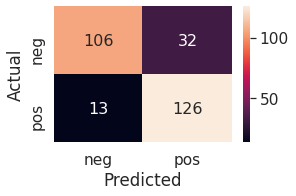

             # of True Negatives: 	 106 
             # of False Positives: 	 32 
             # of False Negatives: 	 13 
             # of True Positives: 	 126 

>**Confusion Matrix with Naive Bayes/BOW is:**

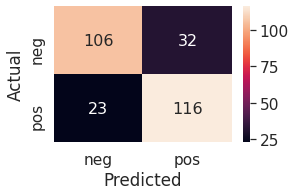

            # of True Negatives:    106 
            # of False Positives:   32 
            # of False Negatives:   23 
            # of True Positives:   116 

 >**Classification report with SGD/TF-IDF/Bi-gram is:**

                  precision    recall  f1-score   support

             neg       0.89      0.77      0.82       138
             pos       0.80      0.91      0.85       139

        accuracy                           0.84       277
       macro avg       0.84      0.84      0.84       277
    weighted avg       0.84      0.84      0.84       277


 >**Classification report with Naive Bayes/BOW is:**

                  precision    recall  f1-score   support

             neg       0.82      0.77      0.79       138
             pos       0.78      0.83      0.81       139

        accuracy                           0.80       277
       macro avg       0.80      0.80      0.80       277
    weighted avg       0.80      0.80      0.80       277


**References:**

Singh, P., 2019. *Fundamentals of bag of words and tf-idf*   [Online]. Available from: https://medium.com/analytics-vidhya/fundamentals-of-bag-of-words-and-tf-idf-9846d301ff22 [Accessed 08 April 2021].

Islam, M. M., Sultana, N., 2018. Comparative Study on Machine Learning Algorithms for Sentiment Classification. *International Journal of Computer Applications*, 182(21), pp.3-5.

 X_test accuracy with SGD/TF-IDF/Bi-gram is:  0.838
 X_test accuracy with Naive Bayes is:  0.801 

 Confusion Matrix with SGD/TF-IDF/Bi-gram is: 
 


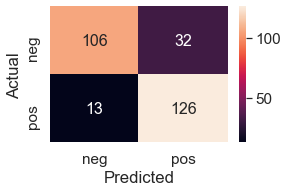

 	 # of True Negatives 	: 106 
 	 # of False Positives 	: 32 
 	 # of False Negatives 	: 13 
 	 # of True Positives 	: 126 

 Confusion Matrix with Naive Bayes/BOW is: 
 


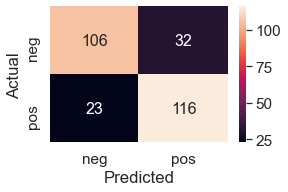

	 # of True Negatives 	: 106 
 	 # of False Positives 	: 32 
 	 # of False Negatives 	: 23 
 	 # of True Positives 	: 116 

 Classification report with SGD/TF-IDF/Bi-gram is: 
                precision    recall  f1-score   support

         neg       0.89      0.77      0.82       138
         pos       0.80      0.91      0.85       139

    accuracy                           0.84       277
   macro avg       0.84      0.84      0.84       277
weighted avg       0.84      0.84      0.84       277

 Classification report with Naive Bayes/BOW is: 
                precision    recall  f1-score   support

         neg       0.82      0.77      0.79       138
         pos       0.78      0.83      0.81       139

    accuracy                           0.80       277
   macro avg       0.80      0.80      0.80       277
weighted avg       0.80      0.80      0.80       277



In [11]:
### Comparison of two classifier Naive Bayes with BOW and SGD with TF-IDF & N-gram ###

# first vectorize X_train_sgd and then encode X_test_sgd and X_validation_sgd accordingly
# so that we dropped words which are not in training set from test and validation sets
# create binary vectorizer using Tf-Idf for better performance
vectorizer_sgd = TfidfVectorizer(binary=True, ngram_range=(1, 2), max_features=200000)
vectorizer_sgd.fit(X_train_df)
X_train_sgd = vectorizer_sgd.transform(X_train_df).toarray()
X_test_sgd = vectorizer_sgd.transform(X_test_df).toarray()
y_train_sgd, y_test_sgd = y_train_df, y_test_df

# train the SGD classifier with only the training data
sgd = SGDClassifier(random_state=42)
sgd.fit(X_train_sgd, y_train_sgd)

# calculate test accuracy for SGD
predictions2 = sgd.predict(X_test_sgd)
accuracy2 = round(np.count_nonzero(predictions2 == y_test_sgd)/y_test_sgd.shape[0], 3)
print("\033[1m", "X_test accuracy with SGD/TF-IDF/Bi-gram is:", "\033[0m", accuracy2)

# print the accuracy for the old algorithm for the comparison
print("\033[1m", "X_test accuracy with Naive Bayes is:", "\033[0m", accuracy1, "\n")

# create a confusion matrix for the improved algorithm
my_confusion_matrix2 = confusion_matrix(y_test_sgd, predictions2)
print("\033[1m", "Confusion Matrix with SGD/TF-IDF/Bi-gram is: \n", "\033[0m")
df_cm = pd.DataFrame(my_confusion_matrix2, ['neg', 'pos'], ['neg', 'pos'])
plt.figure(figsize=(4,2.5))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# precision, recall and f1 scores calculations for the improved algorithm
precision_score_ = precision_score(y_test_sgd, predictions2, pos_label="neg")
tn2, fn2, fp2, tp2 = my_confusion_matrix2[0, 0], my_confusion_matrix2[0, 1], my_confusion_matrix2[1, 0], my_confusion_matrix2[1, 1]
print(" \t # of True Negatives \t:", tn2, "\n \t # of False Positives \t:", fn2, "\n \t # of False Negatives \t:", fp2, "\n \t # of True Positives \t:", tp2, "\n")

# print confusion matrix, precision, recall, f1 scores for the old algorithm
print("\033[1m", "Confusion Matrix with Naive Bayes/BOW is: \n", "\033[0m")
df_cm = pd.DataFrame(my_confusion_matrix1, ['neg', 'pos'], ['neg', 'pos'])
plt.figure(figsize=(4,2.5))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
print("\t # of True Negatives \t:", tn1, "\n \t # of False Positives \t:", fn1, "\n \t # of False Negatives \t:", fp1, "\n \t # of True Positives \t:", tp1, "\n")

# classification report for precision, recall f1-score and accuracy
matrix2 = classification_report(y_test_sgd, predictions2, labels=["neg", "pos"])
print("\033[1m", 'Classification report with SGD/TF-IDF/Bi-gram is: \n', "\033[0m", matrix2)

# print classification report for the old algorithm
print("\033[1m", 'Classification report with Naive Bayes/BOW is: \n', "\033[0m", matrix1)